<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/hungarian/python/area.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Az egyszerű algoritmustól a vektorizáláson át az osztályokig

A koordinátákból területszámítás egyszerű számítási példáján keresztül mutatunk be Python programozási megoldásokat.

Egy zárt sokszög idom területét a koordinátákból az alábbi képlettel számíthatjuk ki:

$2T = \sum_1^n (x_i + x_{i+1}) (y_i - y_{i+1})$

A fenti képletben az utolsó pont esetén (i = n) az i+1 az első pontra vonatkozik. Az idom területét az egyes oldalakhoz tartozó trapézok területének összegzésével számítjuk ki. A trapéz párhuzamos oldalai az *x* tengellyel párhuzamosak, a negyedik oldal az *y* tengely.

In [9]:
from math import pi, sin, cos
from timeit import timeit       # futási idő méréséhez
import matplotlib.pyplot as plt # grafikon rajzoláshoz
import numpy as np              # mátrix műveletekhez

Egy egyszerű alakzat a képlet értelmezéséhez.
Figyelem a trapézok területe a képletben előjeles szám!

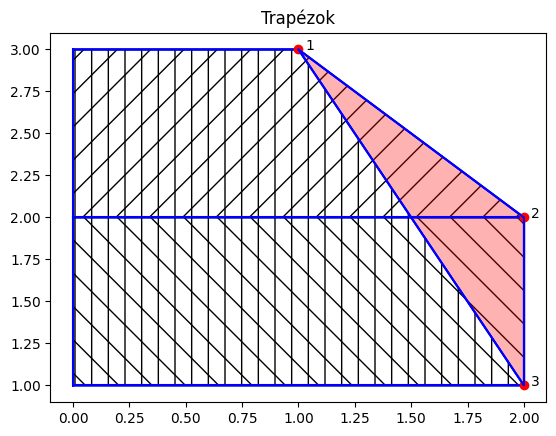

In [10]:
x = [1, 2, 2, 1]    # a kezdőpontot a lista végére is betettük
y = [3, 2, 1, 3]
# a trapézok
h = ['/', '\\', '|']    # sraffozási stílusok
for i in range(len(x)-1):
    # trapézok kitöltése
    plt.fill([0, x[i], x[i+1], 0, 0], [y[i], y[i], y[i+1], y[i+1], y[i]], fill=False, hatch=h[i])
    # trapéz körvonalak
    plt.plot([0, x[i], x[i+1], 0, 0], [y[i], y[i], y[i+1], y[i+1], y[i]], '-b')
plt.plot(x[:-1], y[:-1], 'ro')    # a töréspontok
for i in range(len(x)-1):
    # pontszám feliratok
    plt.annotate(i+1, (x[i]+0.03, y[i]))
plt.fill(x[:-1], y[:-1], 'r', fill=True, alpha=0.3)    # számítandó terület
plt.plot(x, y, '-b')          # az oldalak
_ = plt.title('Trapézok')

## Megoldás ciklussal

Készítsük el az első megoldásunkat a területszámításra függvényként. A koordinátákat egy listában várja, melyben a az egyes pontok koordinátáit egy két elemű lista tartalmazza, a kezdőpontot nem kell megismételni.

In [11]:
def area1(coords):
    """ területszámítás koordinátákból """
    w = 0.0
    for i in range(len(coords)):
        j = (i + 1) % len(coords)   # maradékképzés a kezdőpont megismétléséhez
        w += (coords[j][0] + coords[i][0]) * (coords[j][1] - coords[i][1]) # trapéz terület kétszerese
    return abs(w) /2.0

A *def* alapszó jelöli a függvény kezdetét, utána a függvény neve és zárójelben a paraméterei következnek. A *return* után álló kifejezés értékét adja vissza a függvény.

Próbáljuk ki a függvényünket!

In [12]:
coords = [[634110.62, 232422.09],
          [634108.23, 232365.96],
          [634066.13, 232378.12],
          [634062.95, 232457.58],
          [634111.68, 232454.93]]
print(area1(coords))

3835.1187999993563


## Vektorizálás numpy-al

A hatékonyság érdekében általában célszerű a ciklusokat elkerülni. Ezt vektorizálásnak nevezzük, a ciklusok helyett mátrix műveleteket hajtunk végre. Ehhez a numpy modul segíthet. Írjuk át a függvényünket.

In [13]:
def area2(coo):
    """ területszámítás kordinátákból, vektorizált változat """
    return abs(np.sum(np.multiply(np.add(coo[1:, 0], coo[:-1, 0]), np.diff(coo[:, 1])) / 2))

Értelmezzük a függvényünk egyetlen, a számítást végrehajtó sorát!

A függvény *coo* paramétere egy numpy tömb, mely két oszlopot és a pontok számánál eggyel több sort tartalmaz (az első pontot meg kell ismételni a végén).

A *coo[1:,0]* az x koordinátákat adja vissza a második sortól (a numpy-ban az indexek 0-tól indulnak). A *coo[:-1, 0]* pedig az elsőtől az utolsó előtti x koordinátát adja. Az *np.add* függvény az előző két vektort adja össze, azaz a képlet
$(x_i + x_{i+1})$ részét valósítja meg.

A *coo[:,1]* a második oszlopot, az y koordinátákat adja vissza. Az *np.diff* függvény a szomszédos elemek különbségét adja vissza, azaz a képlet
$(y_i - y_{i+1})$ részét számítja ki.

Az *np.multiply* összeszorozza az x koordináták összegvektorát az y koordináták különbségvektorával, elemenként. Végül az *np.sum* a szorzatokat összegzi.

Próbáljuk ki ezt a függvényt is! Először a *coords* listát átalakítjuk egy numpy tömbbé (*crds*), mely az első pontot utolsóként is tartalmazza.

In [14]:
coords1 = coords.copy()
if coords1[-1] != coords1[0]:
        coords1.append(coords[0])     # kezdőpont megismétlése a lista végén
crds = np.array(coords1)  # átalakítás numpy tömbbé
print(area2(crds))

3835.1187999993563



Hasonlítsuk össze a két megoldást (ciklus és vektorizált), ehhez a *timeit* modult használjuk.

In [22]:
print(f"{area1(coords):.1f} m2 {timeit('area1(coords1)', globals=globals(), number=100_000):.1f} másodperc")
print(f"{area2(crds):.1f} m2 {timeit('area2(crds)', globals=globals(), number=100_000):.1f} másodperc")

3835.1 m2 0.2 másodperc
3835.1 m2 1.3 másodperc


A várakozásainkkal ellentétben az első megoldás a gyorsabb.

Nézzük meg sok pontból álló sokszögre is.

In [49]:
# kör kerületén lévő pontokat generálunk egy listába, a középpont az origó, a sugár és a pontok száma paraméter
def poly_gen(r, n):
    return [[r * cos(i * 2 * pi / n), r * sin(i * 2 * pi / n)] for i in range(n)]

coords2 = poly_gen(500, 1000)
coords3 = np.array(coords2+[coords2[0]])
print(f"terület    : {area1(coords2):.1f} m2")
#print(area2(coords3))
print(f"ciklussal  : {timeit('area1(coords2)', globals=globals(), number=100_000):6.1f} másodperc")
print(f"vektorizált: {timeit('area2(coords3)', globals=globals(), number=100_000):6.1f} másodperc")

terület    : 785393.0 m2
ciklussal  :   39.0 másodperc
vektorizált:    3.0 másodperc


Több töréspont esetén már a vektorizált megoldás a gyorsabb. 30-40 közötti töréspontnál közel azonos a két megoldás futási ideje.

##Sokszög objektumba illesztett megoldás

A sokszögekkel kapcsolatban a területszámítás mellett több más feladat is felmerülhet, például a kerület vagy belső pont generálás. Az osztályok használata esetén egyszerűbben továbbfejleszthető a megoldásunk, könnyebben beilleszthető más programokba.

In [51]:
class Polygon():
    """ Sokszögekkel kapcsolatos számítások
        a sokszög kezdőpontját a végén ismételten tároljuk
    """
    def __init__(self, vertices):
        """ sokszög inicializálása a töréspontok koordinátáival
            listában vagy numpy tömbben
        """
        closed = vertices[0] == vertices[-1]
        if isinstance(vertices, list):
            if not closed:
                vertices.append(vertices[0])    # kezdőpont a végére
            self.vertices = np.array(vertices)
        elif isinstance(vertices, np.ndarray):
            if not closed.any():
                self.vertices = np.append(vertices, np.array([vertices[0]]), 0) # kezdőpont a végére
            else:
                self.vertices = vertices

    def area(self):
        """ területszámítás """
        return abs(np.sum(np.multiply(np.add(self.vertices[1:, 0], self.vertices[:-1, 0]), np.diff(self.vertices[:, 1])) / 2))

    def perimeter(self):
        """ kerület számítás """
        diff = np.diff(self.vertices, axis=0)
        return np.sum(np.sqrt(np.add(np.square(diff[:,0]), np.square(diff[:,1]))))


In [52]:
p = Polygon(coords)
print(f"terület: {p.area():.1f} m2")
print(f"kerület: {p.perimeter():.1f} m")

terület: 3835.1 m2
kerület: 261.2 m
